# Training Notebook

### Students:
> Jonathan Cwengel 

> Tal Zigelnik
          

## Libraries & Dataset import

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import json
from keras.models import Sequential
from tensorflow.keras.models import save_model, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
import cv2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy==1.23.0
!pip install kaggle
kaggle_key = {"username":"talzigelnik","key":"3dde6f3129aa0ff0393a2fe9b1284524"}
os.makedirs('/root/.kaggle', exist_ok=True)
with open(os.path.join('/root/.kaggle', 'kaggle.json'), 'w') as kaggle_json:
    json.dump(kaggle_key, kaggle_json)

!chmod 600 {os.path.join('/root/.kaggle', 'kaggle.json')}

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


# Section A part 1 - Binary Classification
In the first section we will divide the dataset to two labels- Pneumonia and Normal, with one output neuron in the neural network.


## Data handeling and Labeling

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

# Loading the images inside the folders of the dataset
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_data('chest_xray/chest_xray/train')
test = get_data('chest_xray/chest_xray/test')
val = get_data('chest_xray/chest_xray/val')



OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-45-878d96555b54>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



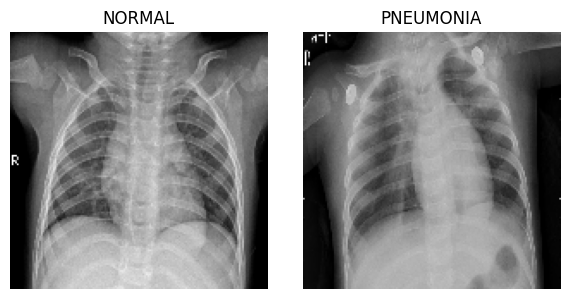

In [ ]:
# Visualization of two images - one is healthy and one is sick
def plot_random_image(data, title):
    random_index = np.random.randint(0, len(data))
    plt.imshow(data[random_index][0], cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
normal_images = train[train[:, 1] == 1]  # Assuming 1 is NORMAL
plot_random_image(normal_images, labels[1])
plt.subplot(1, 2, 2)
pneumonia_images = train[train[:, 1] == 0]  # Assuming 0 is PNEUMONIA
plot_random_image(pneumonia_images, labels[0])
plt.tight_layout()
plt.show()

In [ ]:
# Arranging the classes and labels into x and y
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Counting images for each label in training and validation sets
train_counts = np.unique(y_train, return_counts=True)
val_counts = np.unique(y_val, return_counts=True)
test_counts = np.unique(y_test, return_counts=True)

print("Training set:")
for label, count in zip(train_counts[0], train_counts[1]):
    print(f"Label: {labels[label]}, Count: {count}")

print("\nValidation set:")
for label, count in zip(val_counts[0], val_counts[1]):
    print(f"Label: {labels[label]}, Count: {count}")

print("\nTest set:")
for label, count in zip(test_counts[0], test_counts[1]):
    print(f"Label: {labels[label]}, Count: {count}")



Training set:
Label: PNEUMONIA, Count: 3875
Label: NORMAL, Count: 1341

Validation set:
Label: PNEUMONIA, Count: 8
Label: NORMAL, Count: 8

Test set:
Label: PNEUMONIA, Count: 390
Label: NORMAL, Count: 234


In [ ]:
# We can see the imbalance where the validation set has very little data so lets split some from the training set.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

train_counts = np.unique(y_train, return_counts=True)
val_counts = np.unique(y_val, return_counts=True)
test_counts = np.unique(y_test, return_counts=True)

print("\nTraining set:")
for label, count in zip(train_counts[0], train_counts[1]):
    print(f"Label: {labels[label]}, Count: {count}")

print("\nValidation set:")
for label, count in zip(val_counts[0], val_counts[1]):
    print(f"Label: {labels[label]}, Count: {count}")



Training set:
Label: PNEUMONIA, Count: 3122
Label: NORMAL, Count: 1050

Validation set:
Label: PNEUMONIA, Count: 753
Label: NORMAL, Count: 291


In [ ]:
# Resizing and reshaping values
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)
x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(4172, 150, 150, 1)
(1044, 150, 150, 1)
(624, 150, 150, 1)


In [ ]:
# Building the network's layers
from tensorflow.keras import backend as K
K.clear_session()

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

# Print initial hyperparameters
print(f"Initial Learning Rate: {K.get_value(model.optimizer.lr)}")
print(f"Loss Function: {'binary_crossentropy'}")
print(f"Batch Size: {32}")
print(f"Epochs: {10}")
print(f"Optimizer: {'Adam'}")
print("ReduceLROnPlateau settings:",
      f"Monitor: {'val_accuracy'}, Patience: {2}, Factor: {0.3}, Min_lr: {0.000001}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [ ]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
131/131 [==============================] - 18s 90ms/step - loss: 0.3692 - accuracy: 0.8646 - val_loss: 6.7692 - val_accuracy: 0.7213
Epoch 2/10
131/131 [==============================] - 11s 86ms/step - loss: 0.2619 - accuracy: 0.8981 - val_loss: 6.1955 - val_accuracy: 0.7213
Epoch 3/10
131/131 [==============================] - 11s 86ms/step - loss: 0.2110 - accuracy: 0.9180 - val_loss: 3.8820 - val_accuracy: 0.7213
Epoch 4/10
131/131 [==============================] - 11s 86ms/step - loss: 0.2091 - accuracy: 0.9238 - val_loss: 5.5749 - val_accuracy: 0.7213
Epoch 5/10
131/131 [==============================] - 11s 84ms/step - loss: 0.1884 - accuracy: 0.9259 - val_loss: 0.5304 - val_accuracy: 0.7328
Epoch 6/10
131/131 [==============================] - 11s 86ms/step - loss: 0.1931 - accuracy: 0.9288 - val_loss: 0.4038 - val_accuracy: 0.8678
Epoch 7/10
131/131 [==============================] - 11s 86ms/step - loss: 0.1661 - accuracy: 0.9389 - val_loss: 1.5987 - val_accuracy:

Loss of the model is -  0.1554100066423416
Accuracy of the model is -  94.43911910057068 %


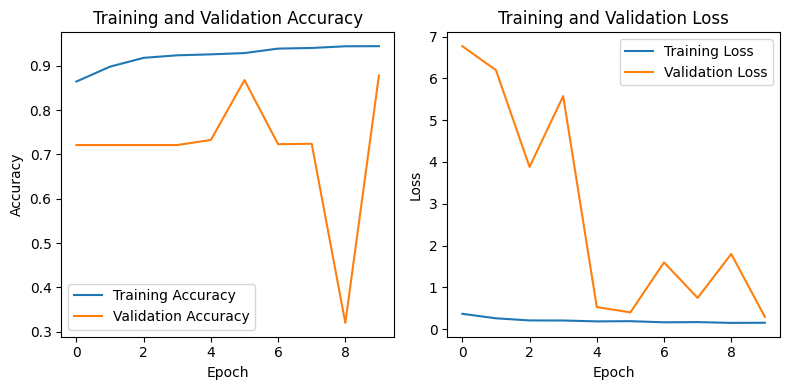

In [ ]:
import matplotlib.pyplot as plt

# Print loss and accuracy
print("Loss of the model is - ", history.history['loss'][-1])
print("Accuracy of the model is - ", history.history['accuracy'][-1] * 100, "%")

# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
# We tried to lessen up the augmentation and got better rsults

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(x_train)

In [ ]:
# Define rate reduction callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

# Train the model using early stopping and learning rate reduction
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[ reduce_lr])

Epoch 1/10
131/131 [==============================] - 12s 94ms/step - loss: 0.1362 - accuracy: 0.9501 - val_loss: 2.7030 - val_accuracy: 0.7213 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 11s 85ms/step - loss: 0.1601 - accuracy: 0.9461 - val_loss: 0.1377 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 11s 84ms/step - loss: 0.1365 - accuracy: 0.9559 - val_loss: 3.1904 - val_accuracy: 0.3305 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 10s 77ms/step - loss: 0.1451 - accuracy: 0.9461 - val_loss: 2.1324 - val_accuracy: 0.4128 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - 11s 85ms/step - loss: 0.1165 - accuracy: 0.9590 - val_loss: 1.2023 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9571
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
131/131 [==============================] -

Loss of the model is -  0.09590595215559006
Accuracy of the model is -  96.88398838043213 %


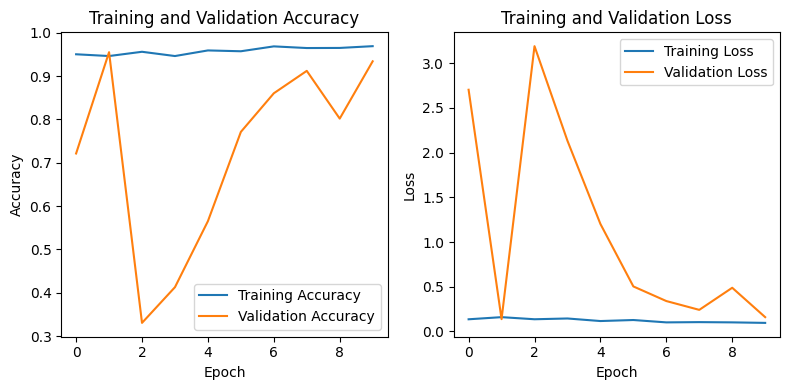

In [ ]:
import matplotlib.pyplot as plt

# Print loss and accuracy
print("Loss of the model is - ", history.history['loss'][-1])
print("Accuracy of the model is - ", history.history['accuracy'][-1] * 100, "%")

# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

20/20 [==============================] - 0s 11ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       390
           1       0.94      0.79      0.86       234

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624

Confusion Matrix:
 [[378  12]
 [ 48 186]]


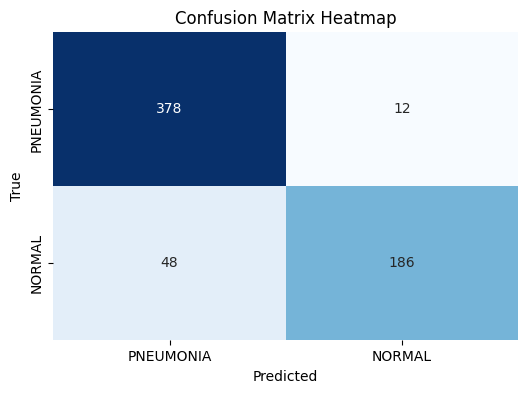

TPR: 79%
TNR: 97%
FPR: 3%
FNR: 21%



In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import seaborn as sns
# Making predictions
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)
accuracy = accuracy_score(y_test, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

tn,fp,fn,tp=conf_matrix.ravel()
TPR=tp/(tp+fn)
TNR=tn/(tn+fp)
FPR=fp/(fp+tn)
FNR=fn/(fn+tp)
print(f'TPR: {round(TPR*100)}%\n'
      f'TNR: {round(TNR*100)}%\n'
      f'FPR: {round(FPR*100)}%\n'
      f'FNR: {round(FNR*100)}%\n')

In [ ]:
# Saving model and history to drive
model.save('/content/drive/MyDrive/Colab Notebooks/DL Basics/saved_models/first model/model.keras')
history_path = '/content/drive/MyDrive/Colab Notebooks/DL Basics/saved_models/first model/training_history.json'

# Convert 'float32' values and 'numpy.ndarray' to standard Python types
def convert(value):
    if isinstance(value, np.ndarray):
        return value.tolist()
    elif isinstance(value, np.float32):
        return float(value)
    else:
        return value

# Save history to a JSON file
history_dict_serializable = {key: convert(value) for key, value in history.history.items()}
with open(history_path, 'w') as json_file:
    json.dump(history_dict_serializable, json_file, default=lambda x: str(x))

# Section A part 2 - Multiclass Classification

In [ ]:
# Now we will arange the dataset differently - traverse the images in the PNEUOMONIA folder to identify which labeled to Bacterial or to Viral kind
class_names = ['Normal', 'Pneumonia_Bacterial', 'Pneumonia_Viral']
img_size = 150
base_dir='/content/chest_xray'
def load_data(dataset_path):
    x = []
    y = []

    for data_split in ["train", "val"]:
        for label in ["NORMAL", "PNEUMONIA"]:
            label_path = os.path.join(base_dir, data_split, label)
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)

                # Read and resize the image
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_size, img_size))

                # Extract label based on the image name
                if "bacteria" in image_name:
                    label = "Pneumonia_Bacterial"
                elif "virus" in image_name:
                    label = "Pneumonia_Viral"
                else:
                    label = "Normal"

                x.append(img)
                y.append(label)

    return np.array(x), np.array(y)

# Load the data
x, y = load_data(base_dir)


# Split the remaining data (training and validation) while maintaining label balance
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

# Print the shapes of the datasets
print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
#print("Test set shape:", x_test.shape)

# Convert labels to numerical encoding
label_to_index = {"Normal": 0, "Pneumonia_Bacterial": 1, "Pneumonia_Viral": 2}
y_train = np.array([label_to_index[label] for label in y_train])
y_val = np.array([label_to_index[label] for label in y_val])
#y_test = np.array([label_to_index[label] for label in y_test])

# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0
x_val = x_val / 255.0
#x_test = x_test / 255.0

# Reshape data for the model
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)
#x_test = x_test.reshape(-1, img_size, img_size, 1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(x_train)

Training set shape: (4185, 150, 150)
Validation set shape: (1047, 150, 150)


In [ ]:
# Count the occurrences of each label in each dataset
train_label_counts = {label: np.sum(y_train == index) for label, index in label_to_index.items()}
val_label_counts = {label: np.sum(y_val == index) for label, index in label_to_index.items()}
#test_label_counts = {label: np.sum(y_test == index) for label, index in label_to_index.items()}

# Print the counts of each label in each dataset
print("Training set label counts:")
for label, count in train_label_counts.items():
    print(f"{label}: {count}")

print("\nValidation set label counts:")
for label, count in val_label_counts.items():
    print(f"{label}: {count}")



Training set label counts:
Normal: 1071
Pneumonia_Bacterial: 2046
Pneumonia_Viral: 1068

Validation set label counts:
Normal: 278
Pneumonia_Bacterial: 492
Pneumonia_Viral: 277


In [ ]:
# Building the neural network and adding layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
K.clear_session()

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding='same'))

model2.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding='same'))

model2.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding='same'))

model2.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding='same'))

model2.add(Flatten())
model2.add(Dense(units=128, activation='relu', name='embedding_layer'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax'))

# Adjust the learning rate
optimizer = Adam(learning_rate=0.0001)

model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

# Train the model
history = model2.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[ reduce_lr])

Epoch 1/10
131/131 [==============================] - 25s 113ms/step - loss: 0.9859 - accuracy: 0.5957 - val_loss: 5.0568 - val_accuracy: 0.2646 - lr: 1.0000e-04
Epoch 2/10
131/131 [==============================] - 12s 91ms/step - loss: 0.7454 - accuracy: 0.6597 - val_loss: 4.9992 - val_accuracy: 0.3410 - lr: 1.0000e-04
Epoch 3/10
131/131 [==============================] - 12s 92ms/step - loss: 0.7063 - accuracy: 0.6800 - val_loss: 4.2699 - val_accuracy: 0.4604 - lr: 1.0000e-04
Epoch 4/10
131/131 [==============================] - 11s 84ms/step - loss: 0.6946 - accuracy: 0.6915 - val_loss: 1.8204 - val_accuracy: 0.4651 - lr: 1.0000e-04
Epoch 5/10
131/131 [==============================] - 12s 93ms/step - loss: 0.6744 - accuracy: 0.6949 - val_loss: 0.8550 - val_accuracy: 0.6103 - lr: 1.0000e-04
Epoch 6/10
131/131 [==============================] - 12s 91ms/step - loss: 0.6515 - accuracy: 0.7185 - val_loss: 0.5897 - val_accuracy: 0.7488 - lr: 1.0000e-04
Epoch 7/10
131/131 [=============

Loss of the model is -  0.6373001933097839
Accuracy of the model is -  72.61648774147034 %


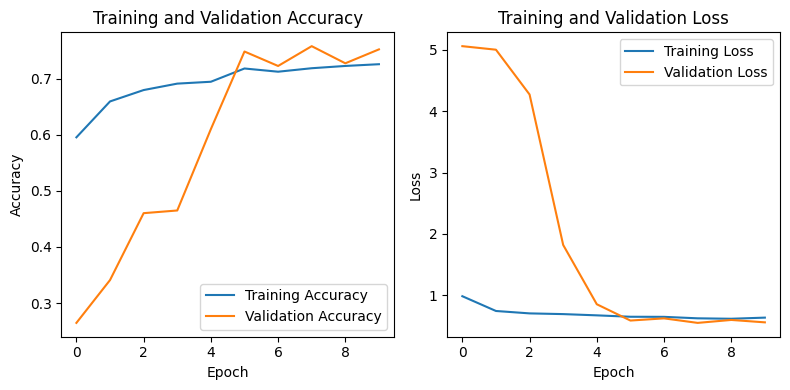

In [ ]:
import matplotlib.pyplot as plt

# Print loss and accuracy
print("Loss of the model is - ", history.history['loss'][-1])
print("Accuracy of the model is - ", history.history['accuracy'][-1] * 100, "%")

# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
model2.save('/content/drive/MyDrive/Colab Notebooks/DL Basics/saved_models/second model/model2.keras')
history_path = '/content/drive/MyDrive/Colab Notebooks/DL Basics/saved_models/second model/training_history.json'

# Convert 'float32' values and 'numpy.ndarray' to standard Python types
def convert(value):
    if isinstance(value, np.ndarray):
        return value.tolist()
    elif isinstance(value, np.float32):
        return float(value)
    else:
        return value

# Save history to a JSON file
history_dict_serializable = {key: convert(value) for key, value in history.history.items()}
with open(history_path, 'w') as json_file:
    json.dump(history_dict_serializable, json_file, default=lambda x: str(x))

# Section B - Embedding Vector and KNN


In [ ]:
from tensorflow.keras.models import load_model
from google.colab import drive
import json
drive.mount('/content/drive')
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/DL Basics/saved_models/second model/model2.keras')
with open('/content/drive/MyDrive/Colab Notebooks/DL Basics/saved_models/second model/training_history.json', 'r') as json_file:
    history = json.load(json_file)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## in order to make this section work without compiling all of the notebook please run the data processing and handeling in the first section

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from google.colab import files

# Function to load and preprocess a new image
def load_and_preprocess_new_image(image_path, target_size=(150, 150), grayscale=True):
    img = cv2.imread(image_path)

    if grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize the image to the target size and normalize pixel values and expand dimensions to match model input shape
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

# Function to get embedding vectors from a model
def get_embedding_vectors(model, images):

    # Create an embedding model with the desired layer as output
    embedding_model = Model(inputs=model.input, outputs=model.get_layer('embedding_layer').output)

    # Get embedding vectors for the input images
    embedding_vectors = embedding_model.predict(images)

    # Flatten the embedding vectors
    flattened_embedding_vectors = embedding_vectors.reshape(len(images), -1)
    return flattened_embedding_vectors

# Loading random image from test folder
#test_image_path = '/content/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg'

### Option to upload a different  image
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    test_image_path = fn


test_image = load_and_preprocess_new_image(test_image_path, grayscale=True)



# Plotting the image
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_image), cmap='gray')
plt.title('Test Image')
plt.axis('off')

# Get the embedding vector using the embedding_model and flattening it
embedding_vector = get_embedding_vectors(model2, test_image)
flattened_embedding_vector = embedding_vector.flatten()

batch_size = 32
flattened_embedding_vectors_from_training_set = []

for start in range(0, len(x_train), batch_size):
    end = start + batch_size
    images_for_embedding = x_train[start:end] / 255.0
    images_for_embedding = images_for_embedding.reshape(-1, 150, 150, 1)
    flattened_embedding_vectors_from_batch = get_embedding_vectors(model2, images_for_embedding)
    flattened_embedding_vectors_from_training_set.append(flattened_embedding_vectors_from_batch)

flattened_embedding_vectors_from_training_set = np.concatenate(flattened_embedding_vectors_from_training_set, axis=0)

# Use k-NN on the flattened embedding vectors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(flattened_embedding_vectors_from_training_set, y_train)

# Predict the class of the new image
predicted_class = knn_classifier.predict([flattened_embedding_vector])[0]
print("Predicted Class:", predicted_class, class_names[predicted_class])


Saving person36_virus_81.jpeg to person36_virus_81.jpeg
User uploaded file "person36_virus_81.jpeg" with length 101154 bytes


NameError: name 'cv2' is not defined

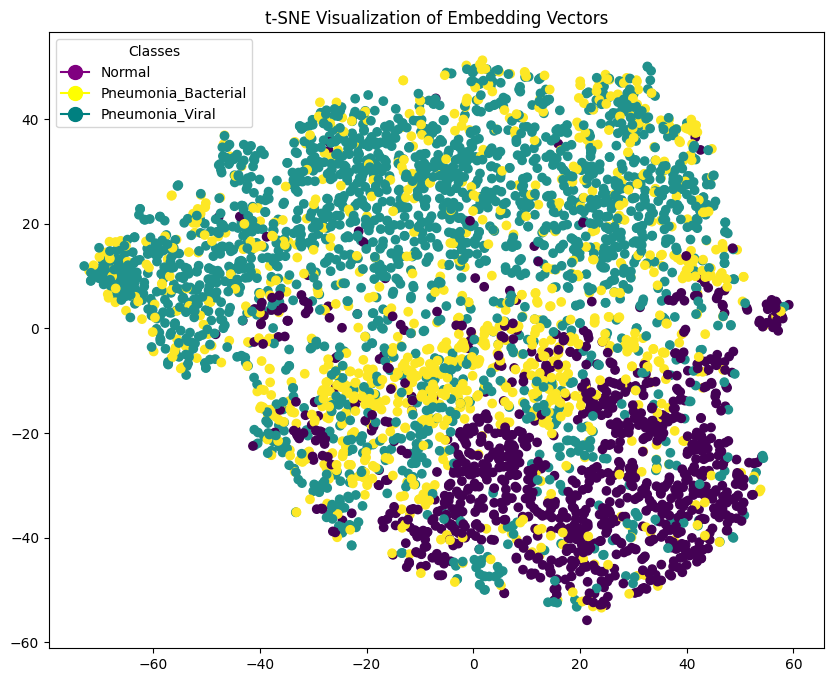

In [ ]:
# Now, let's visualize the embedding vectors using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(flattened_embedding_vectors_from_training_set)

class_colors = ['purple', 'yellow', 'teal']

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=y_train, cmap='viridis')

legend_handles = [plt.Line2D([0], [0], marker='o', color=color, label=name,
                              markerfacecolor=color, markersize=10) for name, color in zip(class_names, class_colors)]
plt.legend(handles=legend_handles, title='Classes')

plt.title('t-SNE Visualization of Embedding Vectors')
plt.show()

#Section D - Anomaly Detection


In [ ]:
# Reloading data like in Section A but this time we changed the img size to 256
labels = ['PNEUMONIA', 'NORMAL']
img_size = 256

# Loading the images inside the folders of the dataset
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_data('chest_xray/chest_xray/train')
test = get_data('chest_xray/chest_xray/test')
val = get_data('chest_xray/chest_xray/val')

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)
x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-27-06dfb3268a55>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.layers import Cropping2D
from keras.models import Sequential

img_size = 256
input_img = Input(shape=(img_size, img_size, 1))

# Encoder
x = Conv2D(128 , (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# # Add another convolutional layer to get the desired output shape
# x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# # Crop the output to match the input shape
# decoded = Cropping2D(((1, 1), (1, 1)))(x)  # Crop to (150, 150, 1)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train the autoencoder using only 'NORMAL' class images
x_normal_train = x_train[y_train == 1]  # Select only 'NORMAL' class images for training
x_normal_val = x_val[y_val == 1]  # Select only 'NORMAL' class images for validation



Model: "model_399"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 128, 128, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        18

In [ ]:
history = autoencoder.fit(
    x_normal_train, x_normal_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(x_normal_val, x_normal_val)
)


Epoch 1/10
33/33 [==============================] - 39s 766ms/step - loss: 0.0240 - val_loss: 0.0062
Epoch 2/10
33/33 [==============================] - 10s 299ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 3/10
33/33 [==============================] - 10s 294ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/10
33/33 [==============================] - 10s 297ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/10
33/33 [==============================] - 10s 314ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/10
33/33 [==============================] - 10s 301ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/10
33/33 [==============================] - 10s 301ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/10
33/33 [==============================] - 10s 304ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/10
33/33 [==============================] - 10s 318ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/10
33/33 [==============================] - 10s 308ms/step - loss: 0.0020 - val_lo

20/20 [==============================] - 4s 208ms/step
Accuracy: 0.3974358974358974
Threshold:  0.002639848767626491


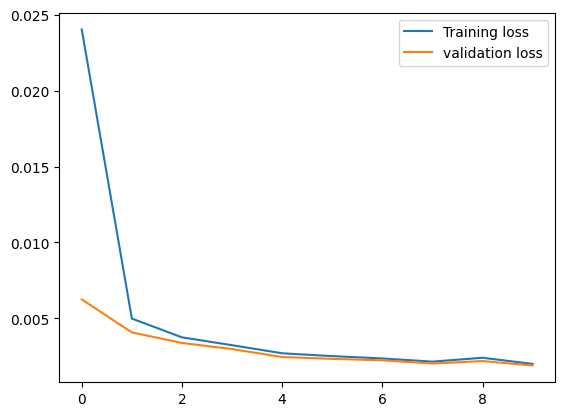

In [ ]:
# Evaluate reconstruction error on test set
reconstructions = autoencoder.predict(x_test)

# Calculate reconstruction error for each image
mse = np.mean(np.square(x_test - reconstructions), axis=(1, 2, 3))

# Define a threshold for anomaly detection
threshold = np.mean(mse) + 2 * np.std(mse)  # Example: Mean + 2*StdDev

# Classify images based on reconstruction error
predicted_labels = ['NORMAL' if error <= threshold else 'PNEUMONIA' for error in mse]

# Evaluate accuracy
accuracy = np.mean(np.array(predicted_labels) == np.array(['NORMAL' if label == 1 else 'PNEUMONIA' for label in y_test]))
print("Accuracy:", accuracy)


print("Threshold: ", threshold)
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Convert predicted labels to binary format (1 for 'NORMAL', 0 for 'PNEUMONIA')
binary_true_labels = y_test  # No need to convert, already in binary format

# Convert predicted labels to binary format (1 for 'NORMAL', 0 for 'PNEUMONIA')
binary_predicted_labels = np.array([1 if label == 'NORMAL' else 0 for label in predicted_labels])

# Calculate accuracy
accuracy = accuracy_score(binary_true_labels, binary_predicted_labels)

# Calculate precision
precision = precision_score(binary_true_labels, binary_predicted_labels)

# Calculate recall
recall = recall_score(binary_true_labels, binary_predicted_labels)

# Calculate F1-score
f1 = f1_score(binary_true_labels, binary_predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(binary_true_labels, binary_predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.3974358974358974
Precision: 0.38006756756756754
Recall: 0.9615384615384616
F1-score: 0.5447941888619854
Confusion Matrix:
[[ 23 367]
 [  9 225]]


In [ ]:
# Predict on the combined test set
test_predictions = autoencoder.predict(x_test)

# Calculate reconstruction error for each image
reconstruction_errors = np.mean(np.square(x_test - test_predictions), axis=(1, 2, 3))

# Classify images as normal (below threshold) or anomalous (above threshold)
predictions = (reconstruction_errors > threshold).astype(int)

# Count the number of predicted pneumonia cases
num_pneumonia_predicted = np.sum(predictions == 1)

print("Number of abnormal cases predicted:", num_pneumonia_predicted)

20/20 [==============================] - 2s 81ms/step
Number of abnormal cases predicted: 32


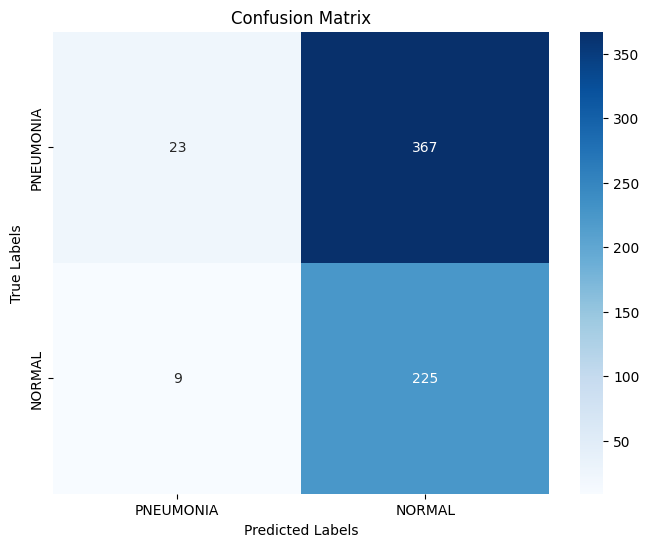

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["PNEUMONIA", "NORMAL"], yticklabels=["PNEUMONIA", "NORMAL"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


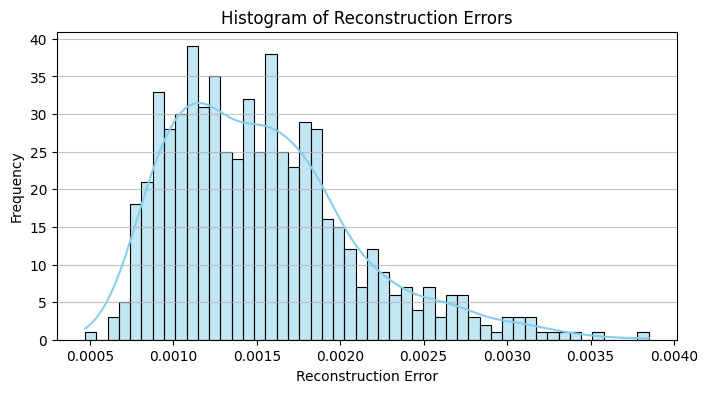

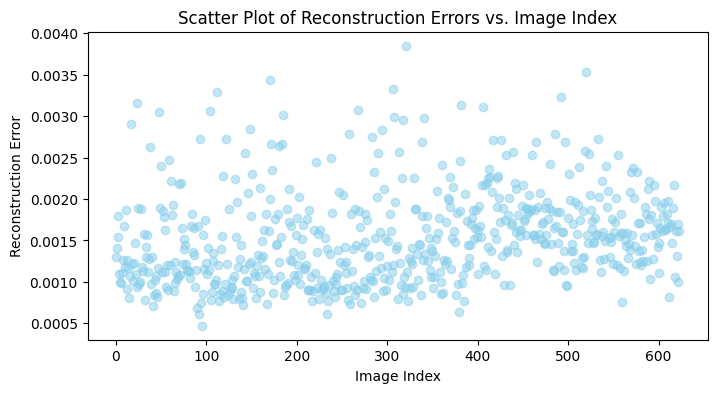

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of reconstruction errors
plt.figure(figsize=(8, 4))
sns.histplot(reconstruction_errors, bins=50, kde=True, color='skyblue')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(8, 4))
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, color='skyblue', alpha=0.5)
plt.title('Scatter Plot of Reconstruction Errors vs. Image Index')
plt.xlabel('Image Index')
plt.ylabel('Reconstruction Error')
plt.show()

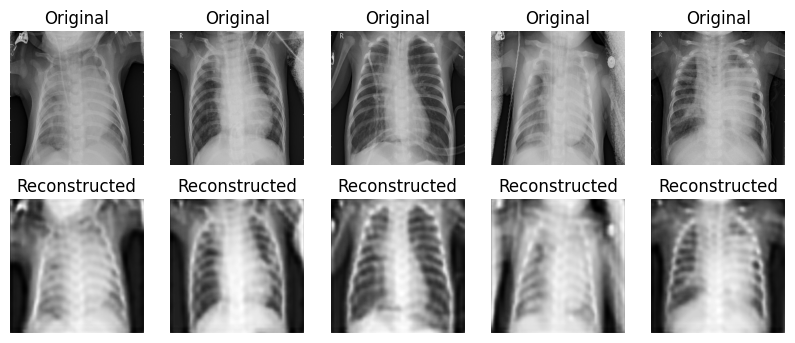

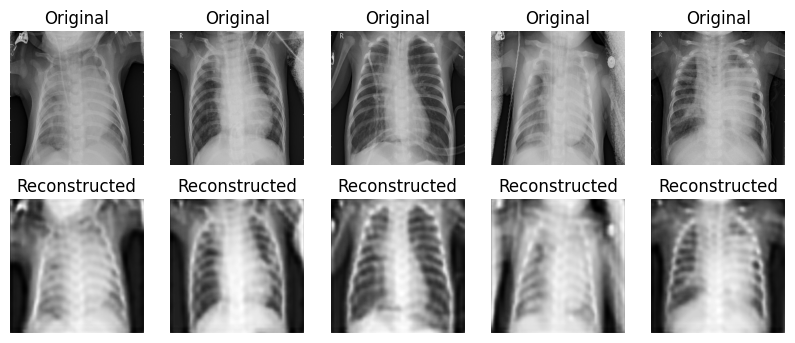

In [ ]:
# 1. Plot some sample reconstructions
n = 5  # Number of samples to plot
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i].reshape(img_size, img_size), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()

# 2. Load and plot some original and reconstructed images side by side
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i].reshape(img_size, img_size), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()

